#Implementation of SVM for textual data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import base64
from io import BytesIO

label_mapping = {
    "Congenital & Genetic": 0,
    "Trauma & Physical Injuries": 1,
    "Vascular & Circulatory": 2,
    "Infections": 3,
    "Neoplasm - Benign & Sarcoma": 4,
    "Neoplasm - Carcinoma": 5,
    "Neoplasm - Other Malignant": 6,
    "Inflammatory & Autoimmune": 7,
    "Metabolic & Endocrine": 8,
    "Cysts & Degenerative Conditions": 9,
    "Obstruction & Structural Abnormalities": 10,
    "Miscellaneous Conditions": 11
}

label_names = {v: k for k, v in label_mapping.items()}

#1) Feature Extraction Techniques:
Used TF-IDF (Term Frequency-Inverse Document Frequency) vectorization with the following specifications:
- max_features=1000: Limits vocabulary to top 1000 most frequent terms
- ngram_range=(1, 1): Captures unigrams
- stop_words='english': Removes common English stop words
- min_df=5: to ignore terms that appear in less than 5 documents
- max_df=0.80: to ignore terms that appear in more than 80% of documents

The text fields (Title, History, Differential Diagnosis, and Location) are concatenated to create a single text document for each record

The vectorizer first builds a vocabulary from all documents, then for each term in the vocabulary:
- Calculates TF: How often it appears in each document
- Calculates IDF: How unique/important it is across all documents
- Combines them into TF-IDF scores

Benifits:
- Rare medical terms get higher weights (e.g., "diverticulum", "atelectasis")
- Common words get lower weights (e.g., "patient", "shows")
- Captures both single terms and phrases (bigrams) through ngram_range=(1, 2)
- Removes irrelevant common words through stop_words='english'

Output Format:
- Each document becomes a sparse vector of length 5000 (max_features)
- Each position represents a term's TF-IDF score
- Most positions will be 0 (terms not present in the document)
- This sparse representation is efficient for medical texts which typically use a subset of the medical vocabulary

#2) SVM Model Specifications:
- Kernel: Linear
- C=0.2: Regularization parameter
- probability=True: Enables probability estimates for ROC curves
- random_state=42: For reproducibility

#3) Data Processing:
- 80-20 train-test split with random seed for reproducibility
- Text preprocessing includes concatenation of relevant fields
- Labels are mapped to numerical values using the provided mapping

#4) Evaluation Metrics:
- Accuracy: Overall correct predictions
- Precision: Weighted average precision across all classes
- Recall: Weighted average recall across all classes
- F1-Score: Weighted average F1 score
- Confusion Matrix: Visual representation of predictions
- ROC Curves and AUC: For each class
- Specificity and Sensitivity: Available through the confusion matrix

In [ ]:
class MedicalTextClassifier:
    def __init__(self, json_file):
        self.json_file = json_file
        self.vectorizer = TfidfVectorizer(
            max_features=1000,
            ngram_range=(1, 1),
            stop_words='english',
            min_df=5,
            max_df=0.80
        )
        self.model = SVC(
            kernel='linear',
            C=0.2,  
            gamma='scale',
            probability=True,
            random_state=42
        )

    def load_and_preprocess_data(self):
        with open(self.json_file, 'r') as f:
            data = json.load(f)

        texts = []
        labels = []

        for record in data:
            text = f"{record['Case'].get('Title','')} {record['Case'].get('History','')} {record['Case'].get('Differential Diagnosis','')} {record.get('Location','')} "
            texts.append(text)
            labels.append(label_mapping[record['Class/Label']])

        return texts, np.array(labels)

    def prepare_data(self):
        texts, labels = self.load_and_preprocess_data()

        X_train, X_test, y_train, y_test = train_test_split(
            texts, labels, test_size=0.2, random_state=42
        )

        X_train_tfidf = self.vectorizer.fit_transform(X_train)
        X_test_tfidf = self.vectorizer.transform(X_test)

        return X_train_tfidf, X_test_tfidf, y_train, y_test

    def train(self):
        X_train_tfidf, X_test_tfidf, y_train, y_test = self.prepare_data()

        self.model.fit(X_train_tfidf, y_train)

        y_train_pred = self.model.predict(X_train_tfidf)
        y_test_pred = self.model.predict(X_test_tfidf)
        y_test_pred_proba = self.model.predict_proba(X_test_tfidf)

        return X_train_tfidf, X_test_tfidf, y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba

    def evaluate(self, y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba):
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        train_precision = precision_score(y_train, y_train_pred, average='weighted')
        test_precision = precision_score(y_test, y_test_pred, average='weighted')

        train_recall = recall_score(y_train, y_train_pred, average='weighted')
        test_recall = recall_score(y_test, y_test_pred, average='weighted')

        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        print("\nTraining Metrics:")
        print(f"Accuracy: {train_accuracy:.4f}")
        print(f"Precision: {train_precision:.4f}")
        print(f"Recall: {train_recall:.4f}")
        print(f"F1-Score: {train_f1:.4f}")

        print("\nTest Metrics:")
        print(f"Accuracy: {test_accuracy:.4f}")
        print(f"Precision: {test_precision:.4f}")
        print(f"Recall: {test_recall:.4f}")
        print(f"F1-Score: {test_f1:.4f}")

        print("\nDetailed Classification Report:")
        print(classification_report(y_test, y_test_pred, target_names=[label_names[i] for i in range(len(label_names))]))

        cm = confusion_matrix(y_test, y_test_pred)

        os.makedirs('output', exist_ok=True)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[label_names[i] for i in range(len(label_names))],
                    yticklabels=[label_names[i] for i in range(len(label_names))])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        confusion_matrix_path = os.path.join('output', 'confusion_matrix.png')
        plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
        print("\nConfusion Matrix:")
        self._display_image(plt)
        plt.close()

        n_classes = len(label_mapping)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'{label_names[i]} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for All Classes')
        plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
        plt.tight_layout()

        roc_curves_path = os.path.join('output', 'roc_curves.png')
        plt.savefig(roc_curves_path, dpi=300, bbox_inches='tight')
        print("\nROC Curves:")
        self._display_image(plt)
        plt.close()

    def _display_image(self, plt):
        """Helper method to display matplotlib figure in the output"""
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)

        img_str = base64.b64encode(buf.read()).decode('utf-8')

        print(f'<img src="data:image/png;base64,{img_str}" width="800">')

**Testing data after text augmentation**


Training Metrics:
Accuracy: 0.8964
Precision: 0.8963
Recall: 0.8964
F1-Score: 0.8929

Test Metrics:
Accuracy: 0.8291
Precision: 0.8421
Recall: 0.8291
F1-Score: 0.8279

Detailed Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.76      0.76      0.76        25
            Trauma & Physical Injuries       0.84      0.95      0.89        43
                Vascular & Circulatory       0.87      0.87      0.87        46
                            Infections       0.88      0.74      0.81        31
           Neoplasm - Benign & Sarcoma       0.84      0.74      0.79        50
                  Neoplasm - Carcinoma       0.59      0.95      0.73        42
            Neoplasm - Other Malignant       0.81      0.55      0.66        47
             Inflammatory & Autoimmune       0.98      0.88      0.92        48
                 Metabolic & Endocrine       1.00      1.00      1.00        5
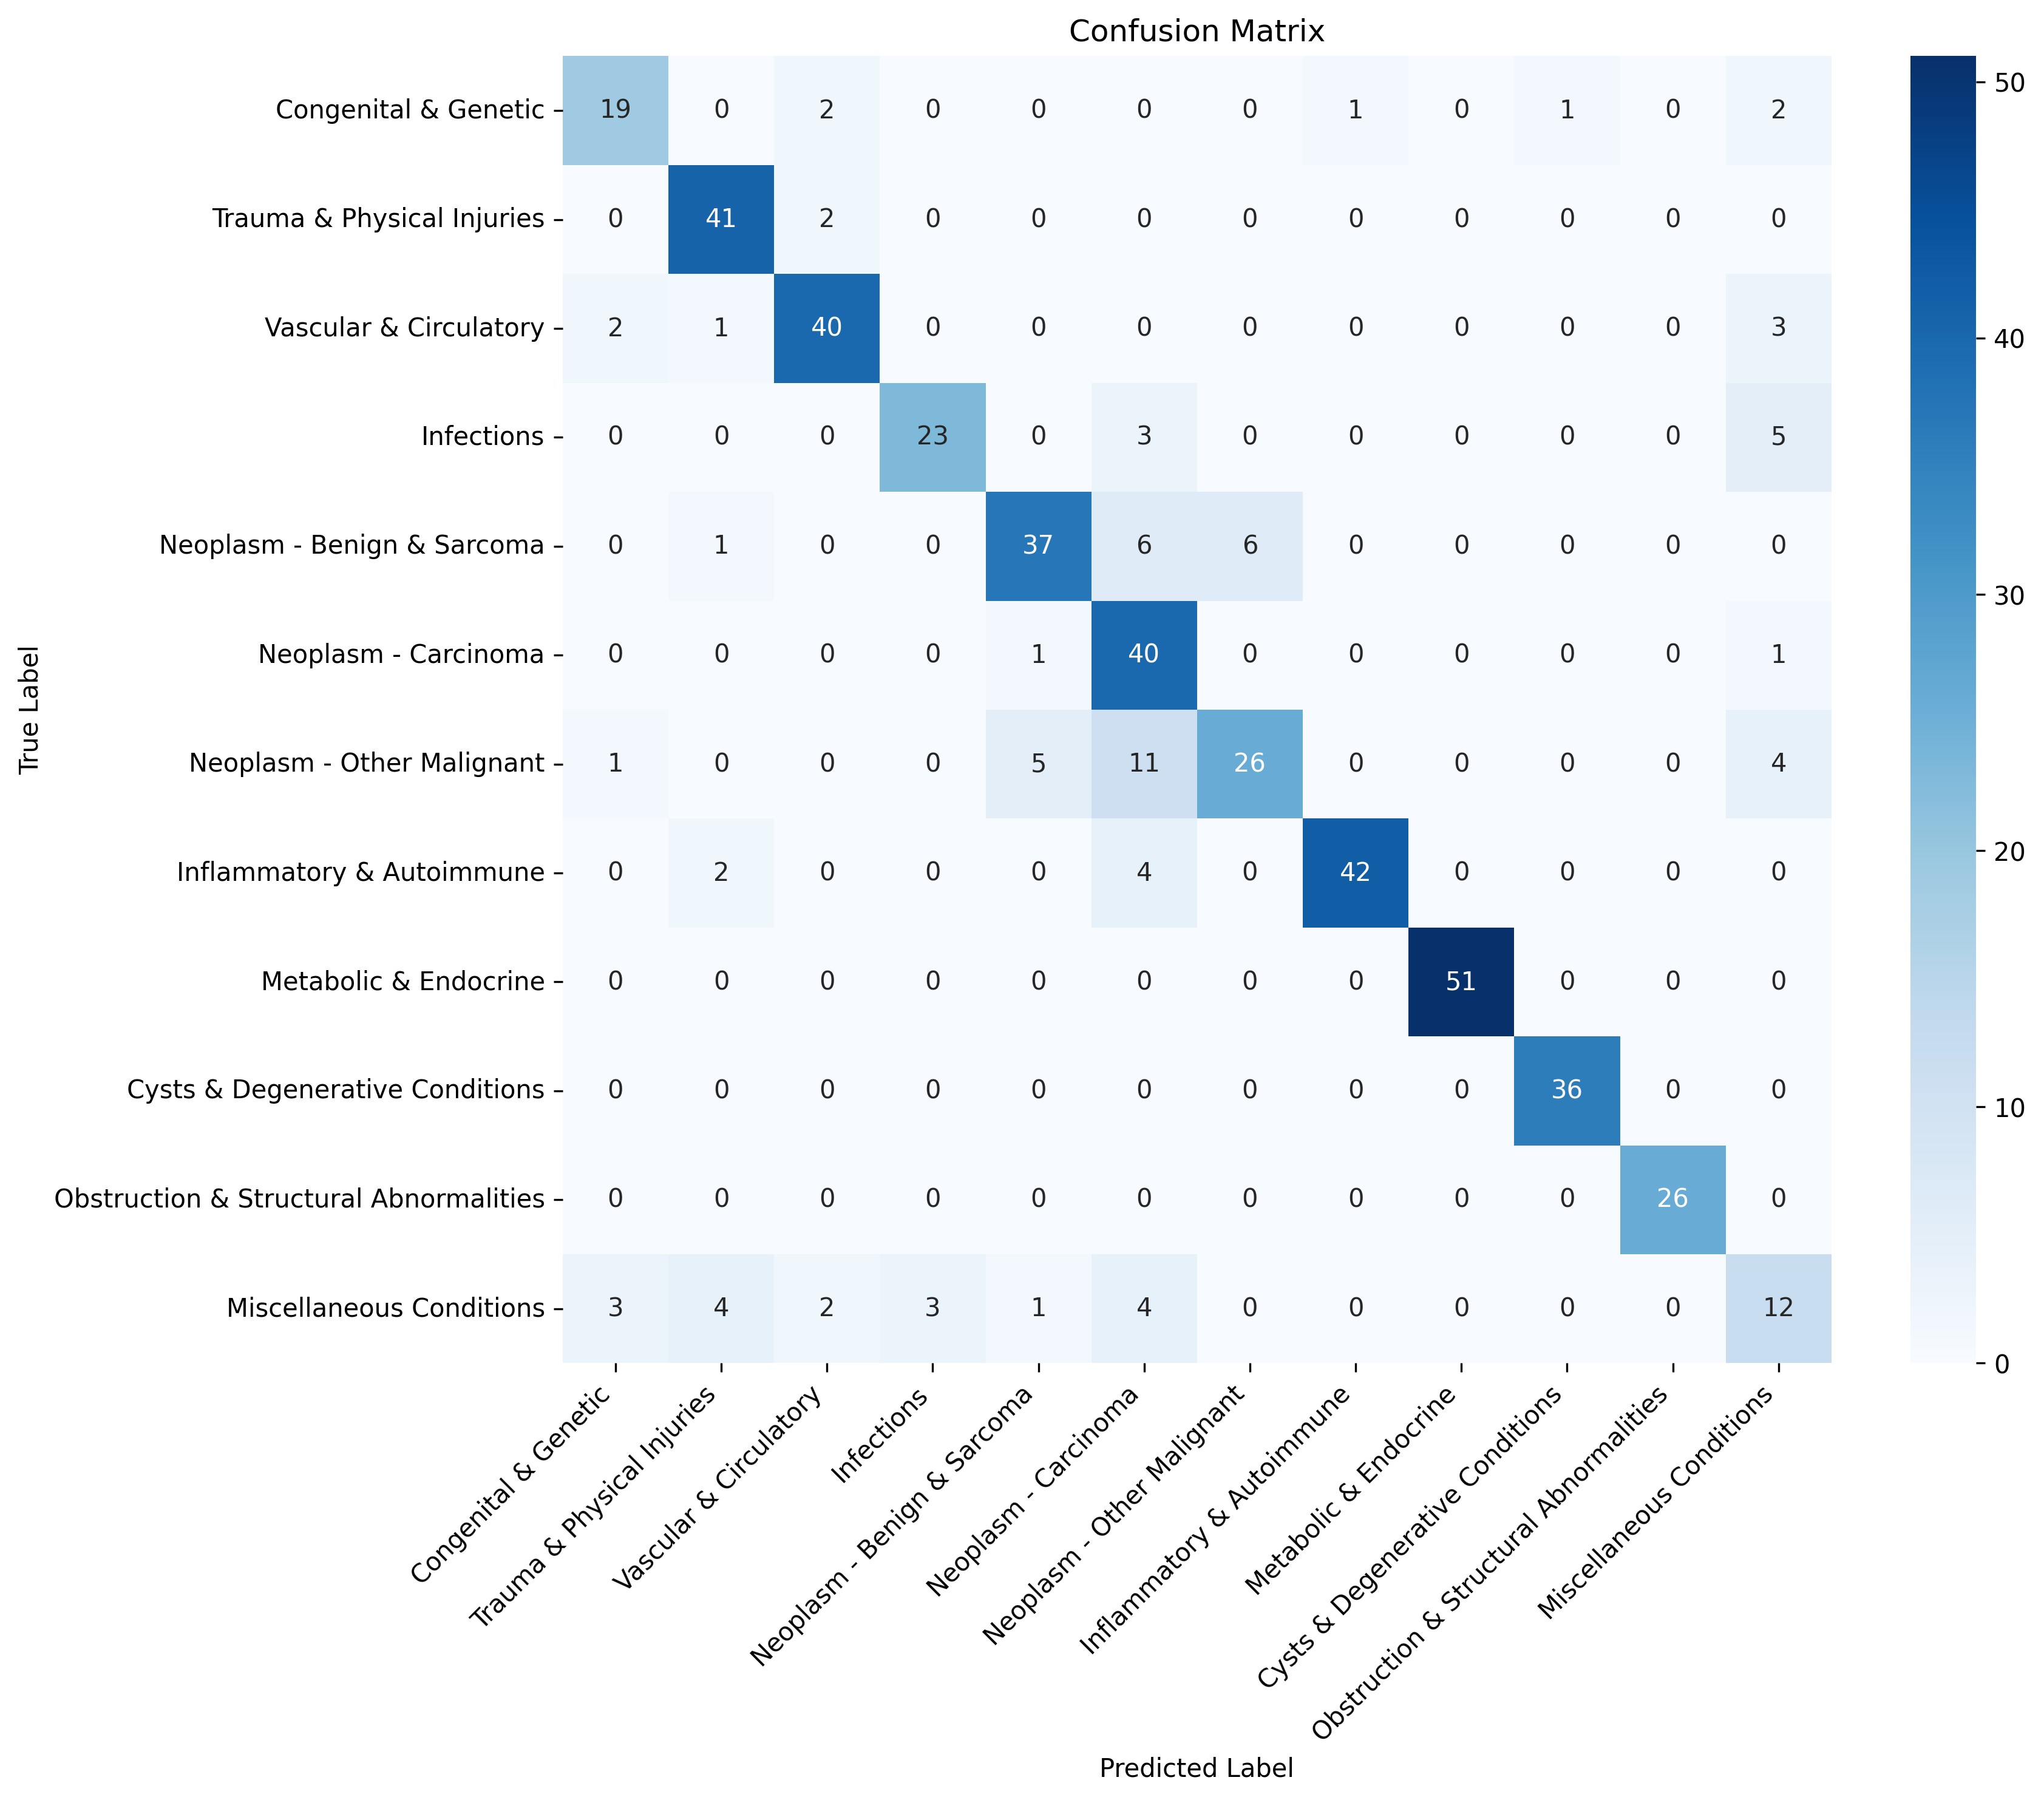
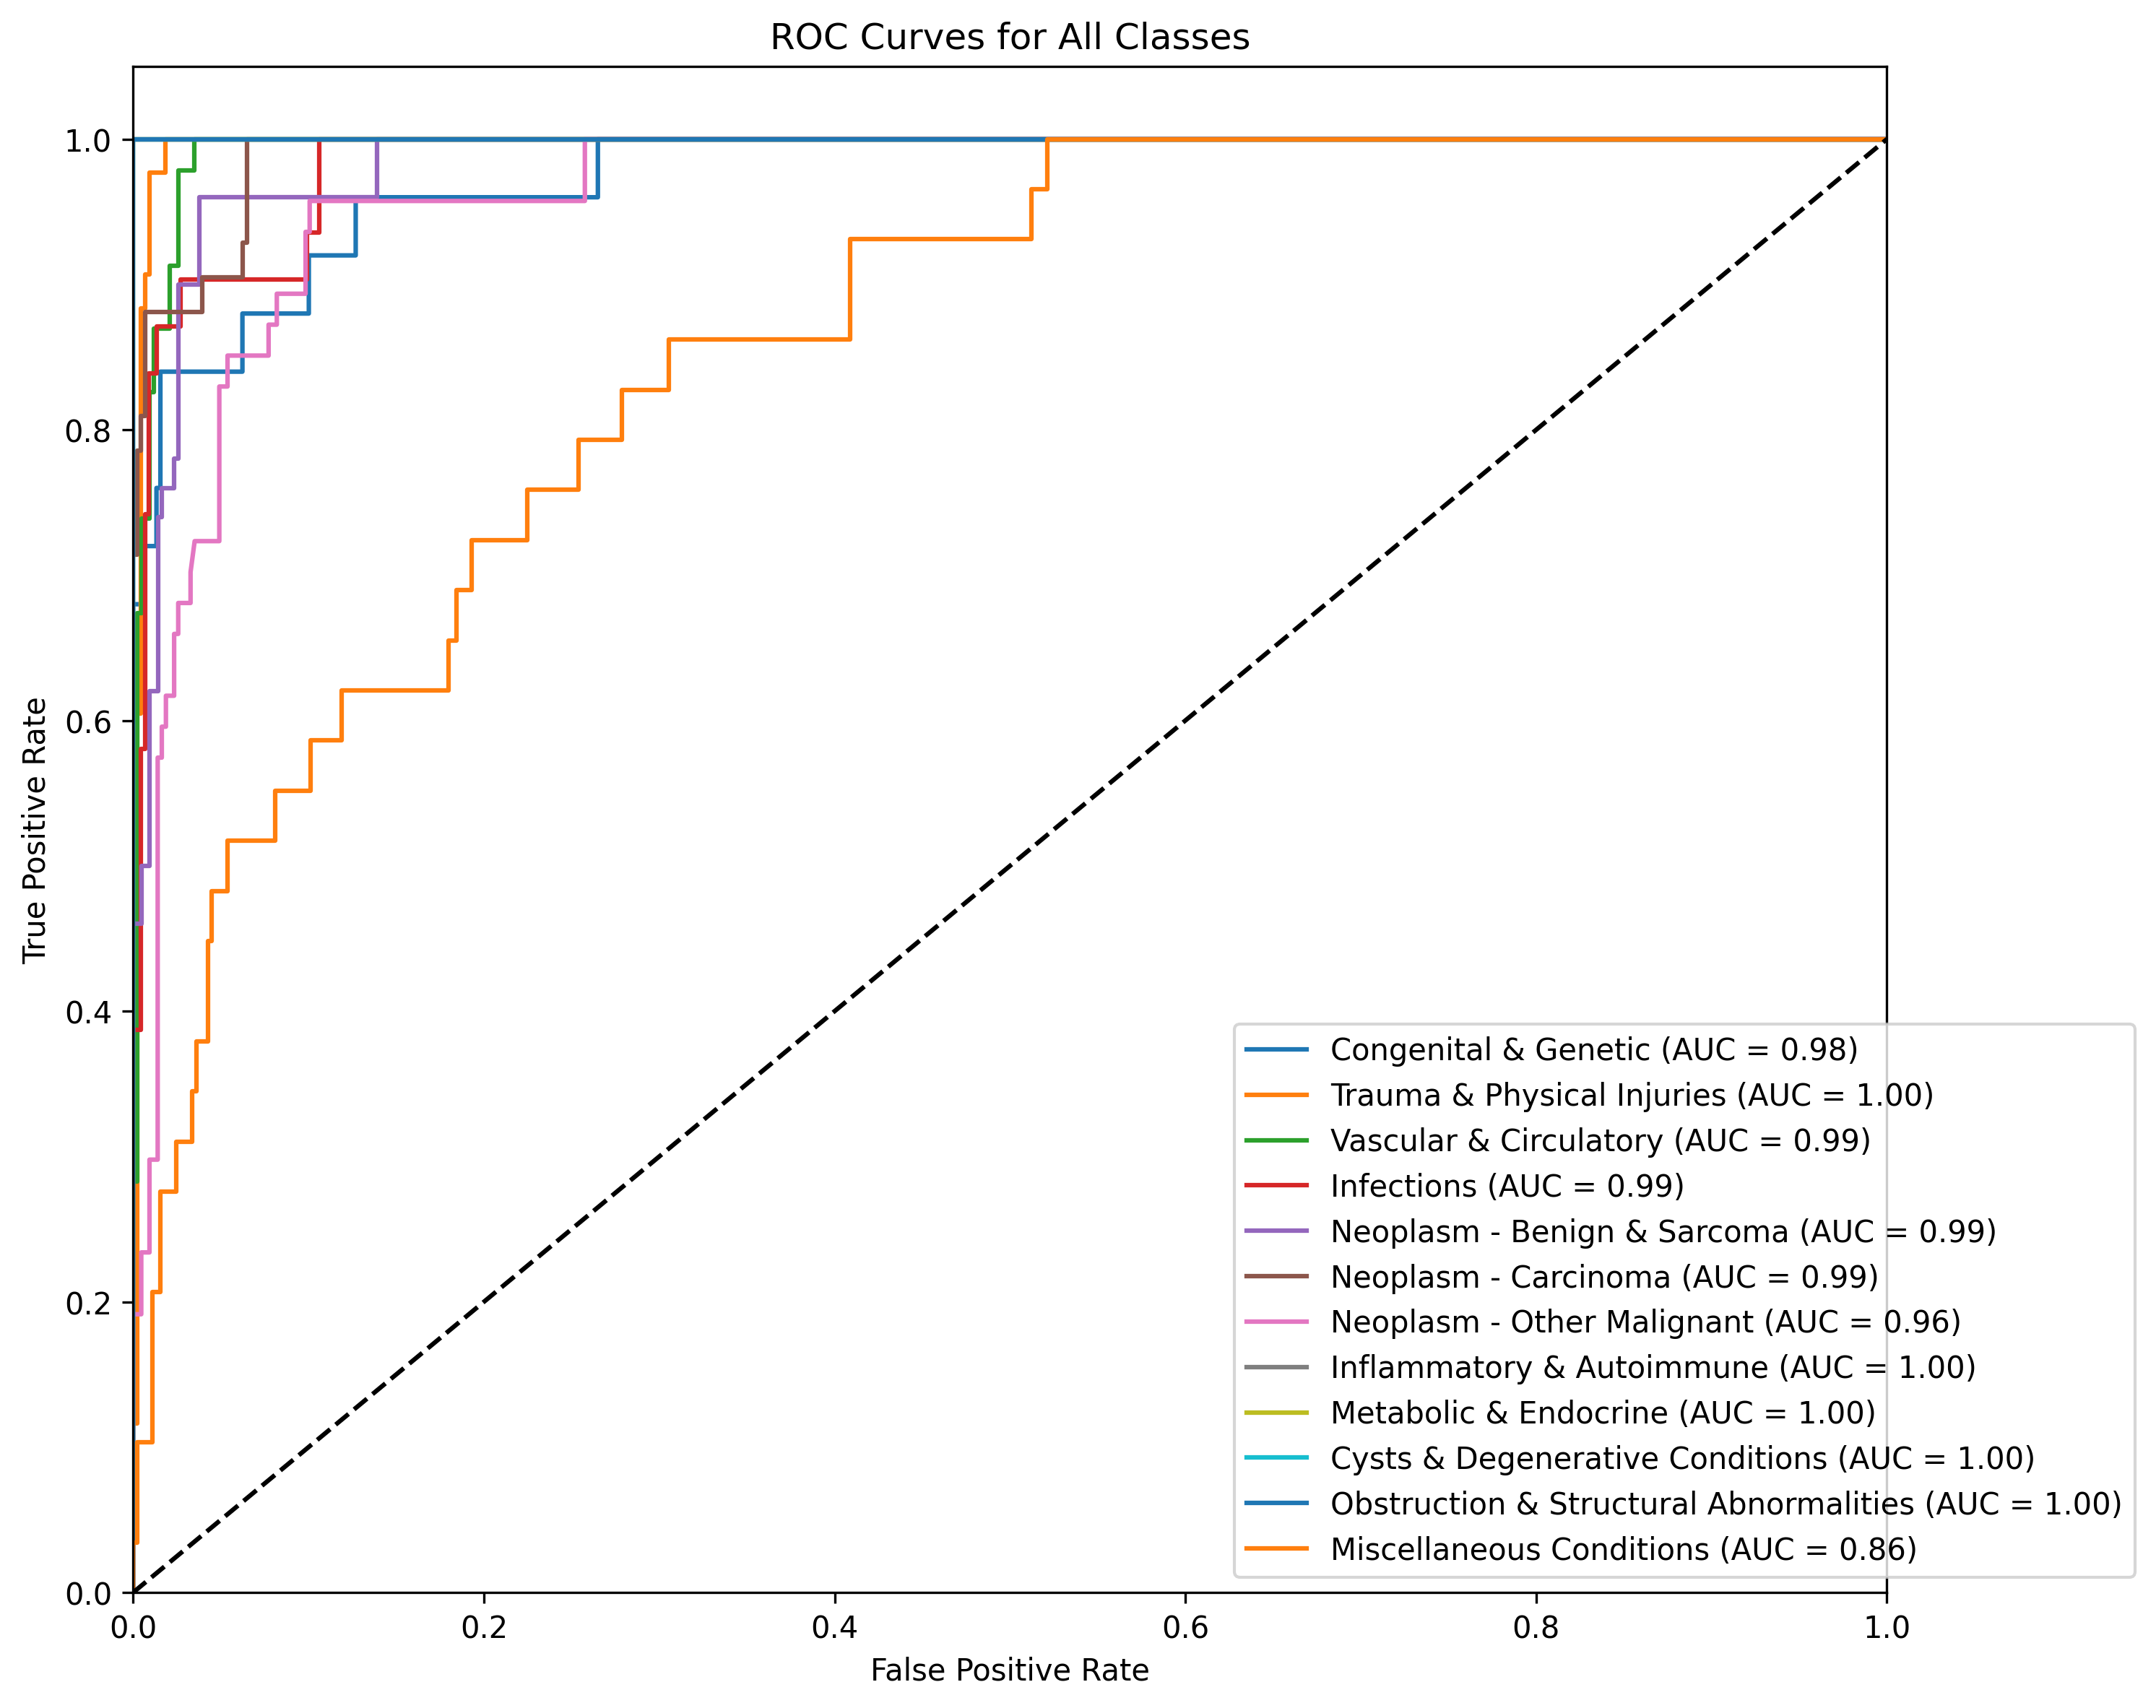

In [ ]:
json_file = "/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Text_Augmented.json"

def main():
    classifier = MedicalTextClassifier(json_file)
    X_train_tfidf, X_test_tfidf, y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba = classifier.train()
    classifier.evaluate(y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba)

if __name__ == "__main__":
    main()

**Testing data after 1 image augmentation**


Training Metrics:
Accuracy: 0.9347
Precision: 0.9360
Recall: 0.9347
F1-Score: 0.9311

Test Metrics:
Accuracy: 0.8955
Precision: 0.8961
Recall: 0.8955
F1-Score: 0.8887

Detailed Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.94      0.69      0.79        70
            Trauma & Physical Injuries       0.87      0.91      0.89        88
                Vascular & Circulatory       0.81      1.00      0.90        82
                            Infections       0.91      1.00      0.95        60
           Neoplasm - Benign & Sarcoma       0.89      0.89      0.89       101
                  Neoplasm - Carcinoma       0.81      1.00      0.89        84
            Neoplasm - Other Malignant       0.82      0.69      0.75        85
             Inflammatory & Autoimmune       0.97      1.00      0.99       102
                 Metabolic & Endocrine       1.00      1.00      1.00        6
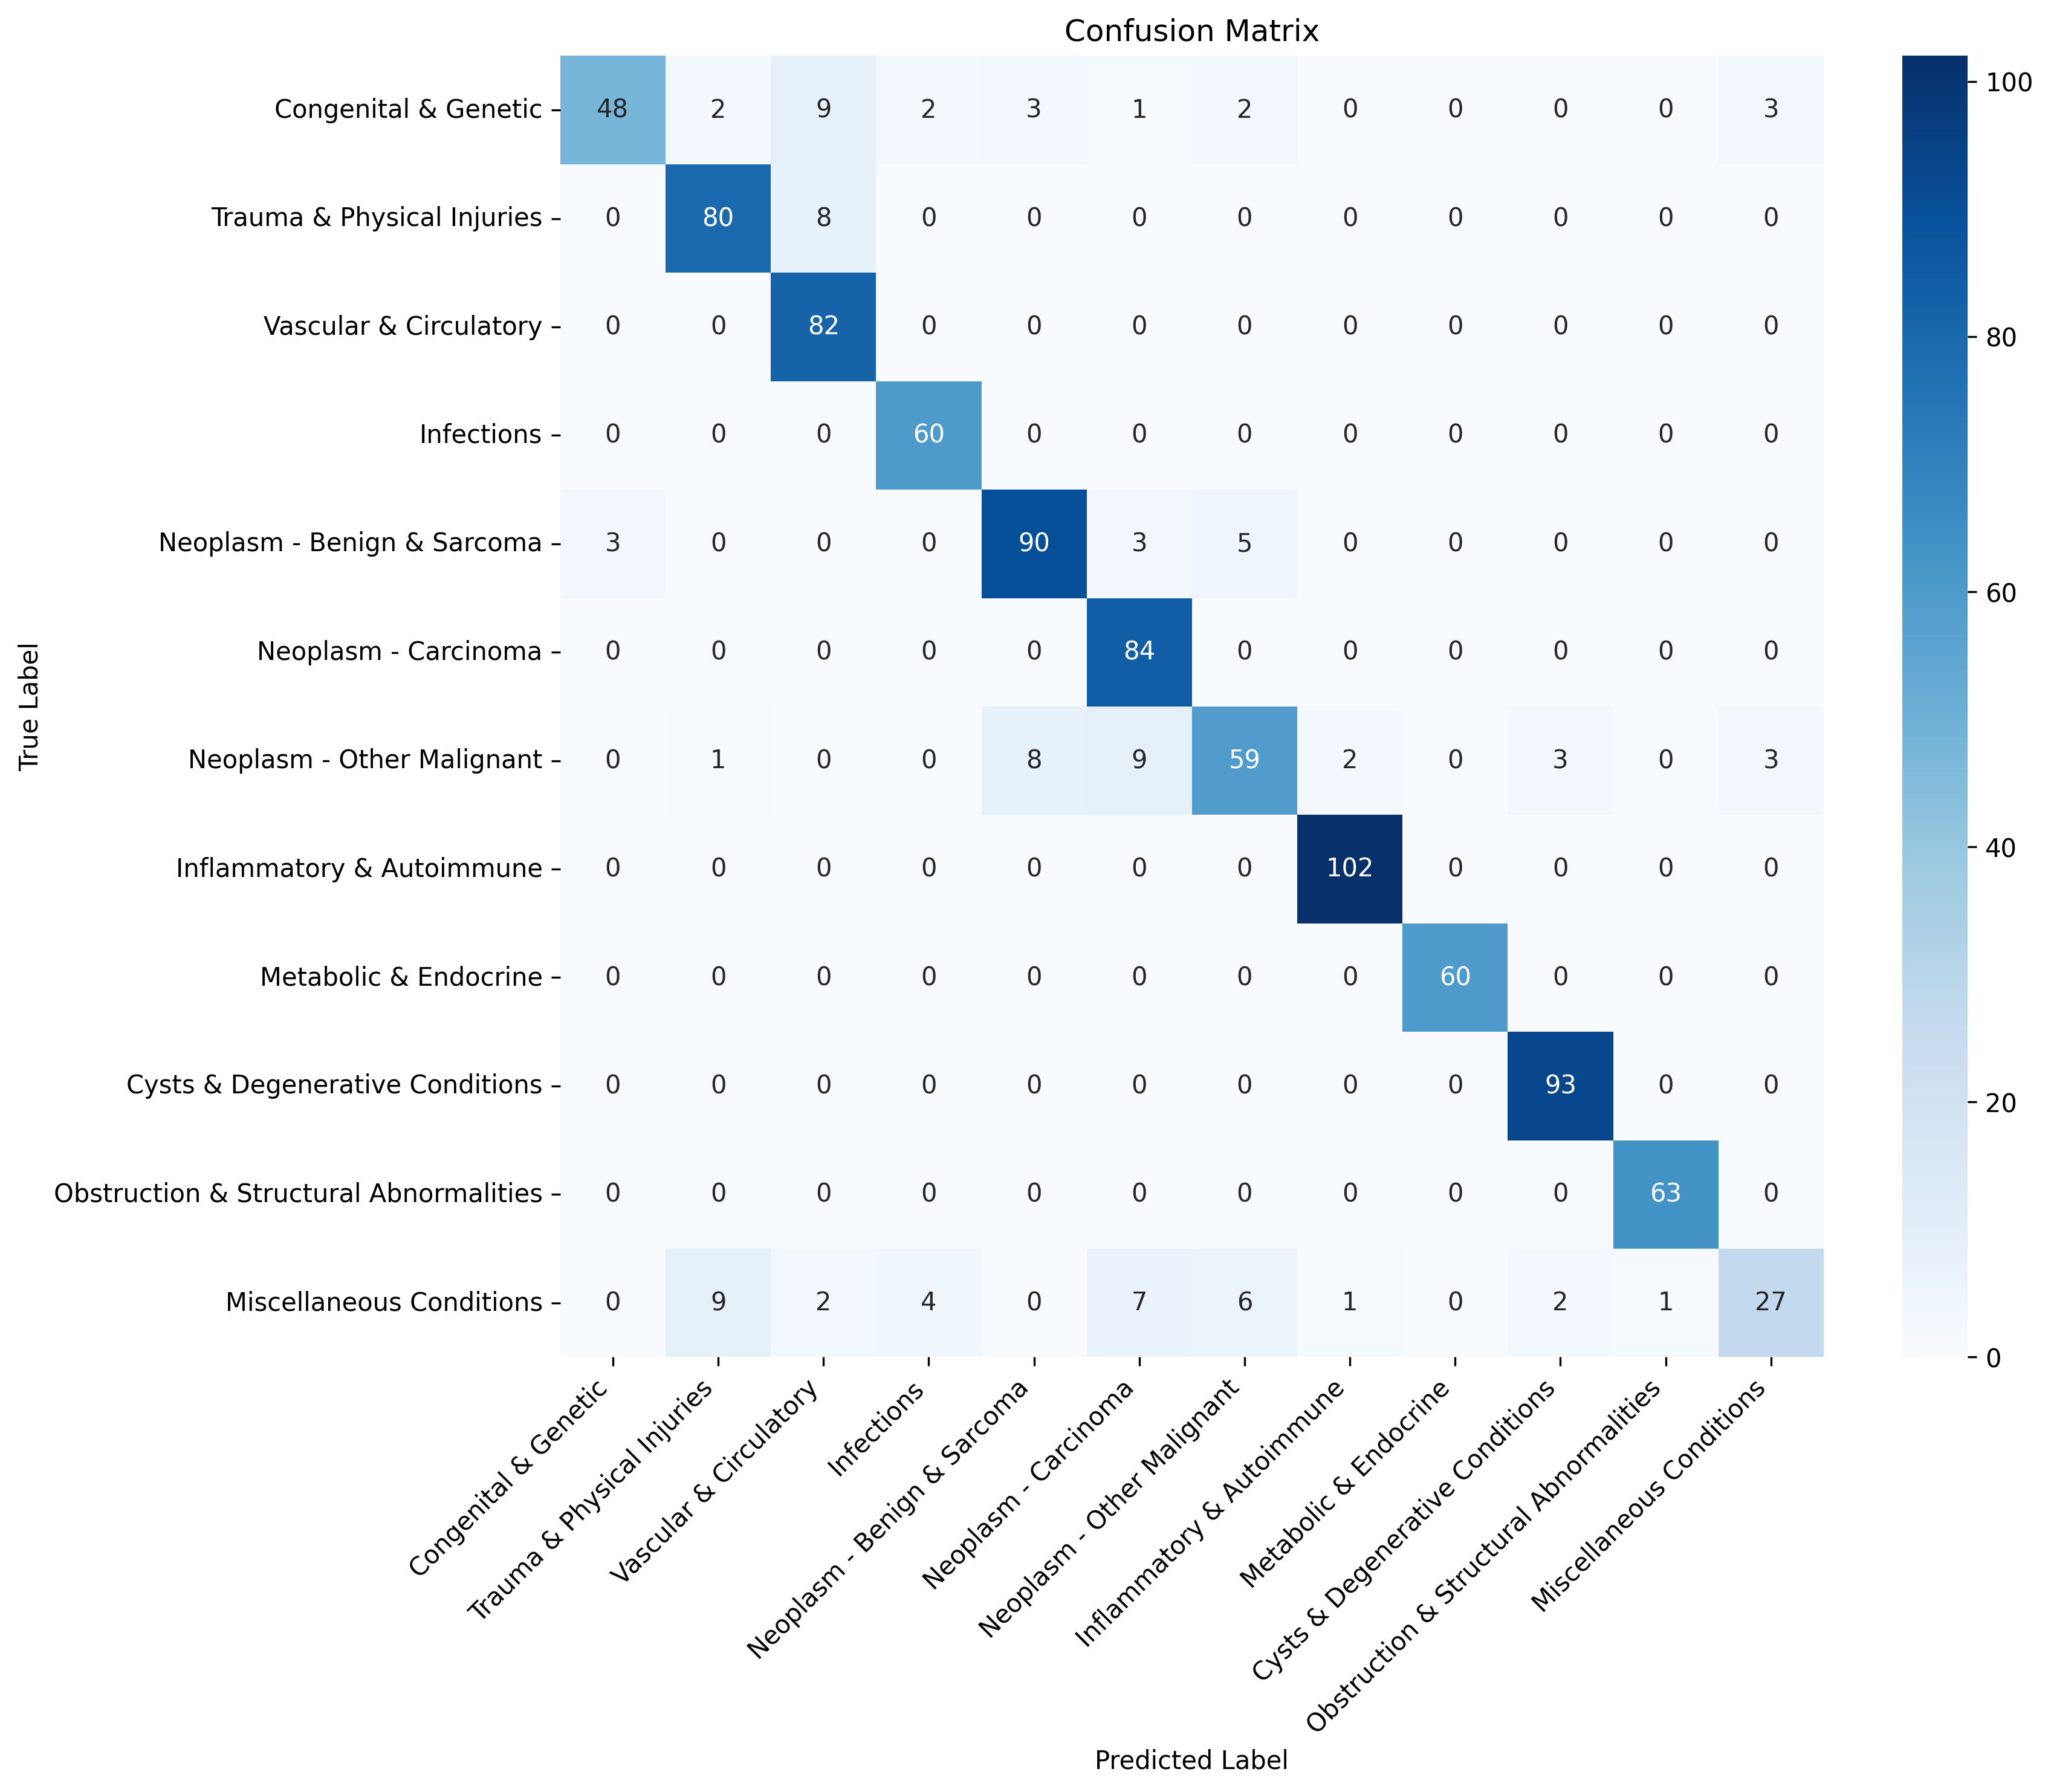
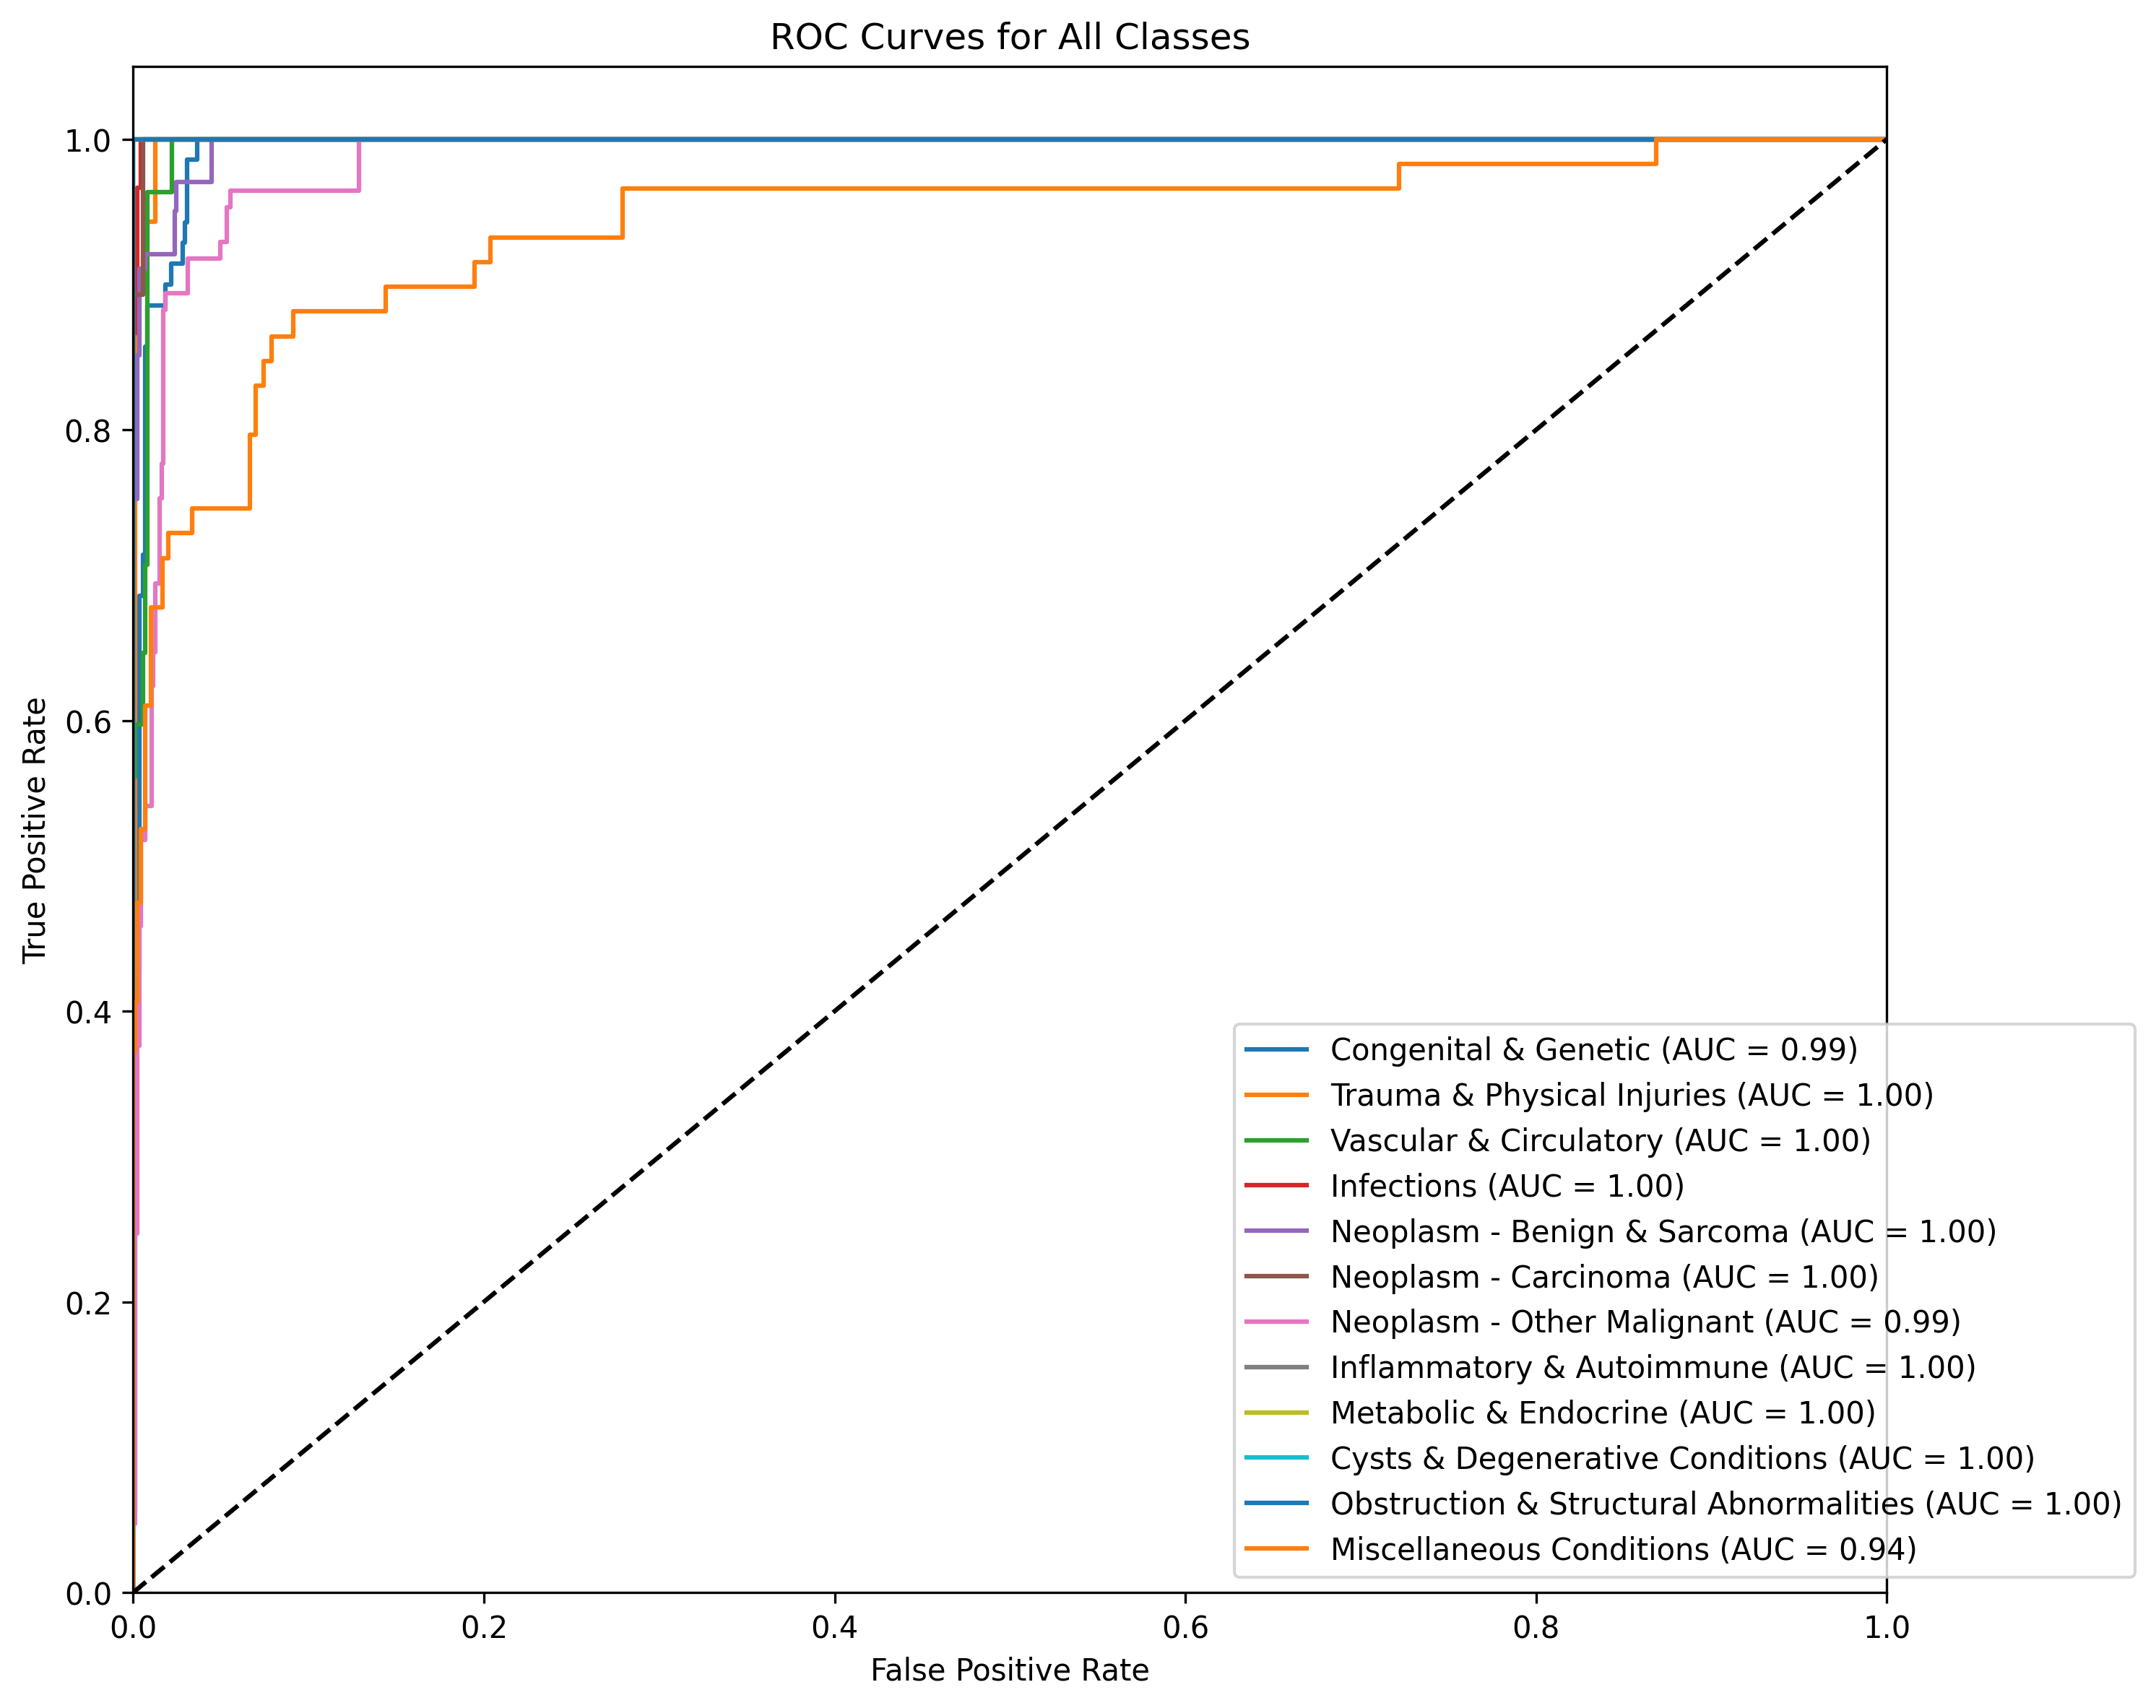

In [ ]:
json_file = "/content/drive/MyDrive/GP2/5_After_1-Image_Augmentation/Image_1_Augmented.json"

def main():
    classifier = MedicalTextClassifier(json_file)
    X_train_tfidf, X_test_tfidf, y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba = classifier.train()
    classifier.evaluate(y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba)

if __name__ == "__main__":
    main()

**Testing data after 2 image augmentations**


Training Metrics:
Accuracy: 0.9551
Precision: 0.9561
Recall: 0.9551
F1-Score: 0.9523

Test Metrics:
Accuracy: 0.9239
Precision: 0.9272
Recall: 0.9239
F1-Score: 0.9145

Detailed Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.90      0.88      0.89        97
            Trauma & Physical Injuries       0.93      0.97      0.95       153
                Vascular & Circulatory       0.93      0.99      0.96       115
                            Infections       0.84      1.00      0.91        95
           Neoplasm - Benign & Sarcoma       0.85      1.00      0.92       140
                  Neoplasm - Carcinoma       0.92      1.00      0.96       111
            Neoplasm - Other Malignant       0.85      0.82      0.84       120
             Inflammatory & Autoimmune       0.99      1.00      1.00       140
                 Metabolic & Endocrine       1.00      1.00      1.00       13
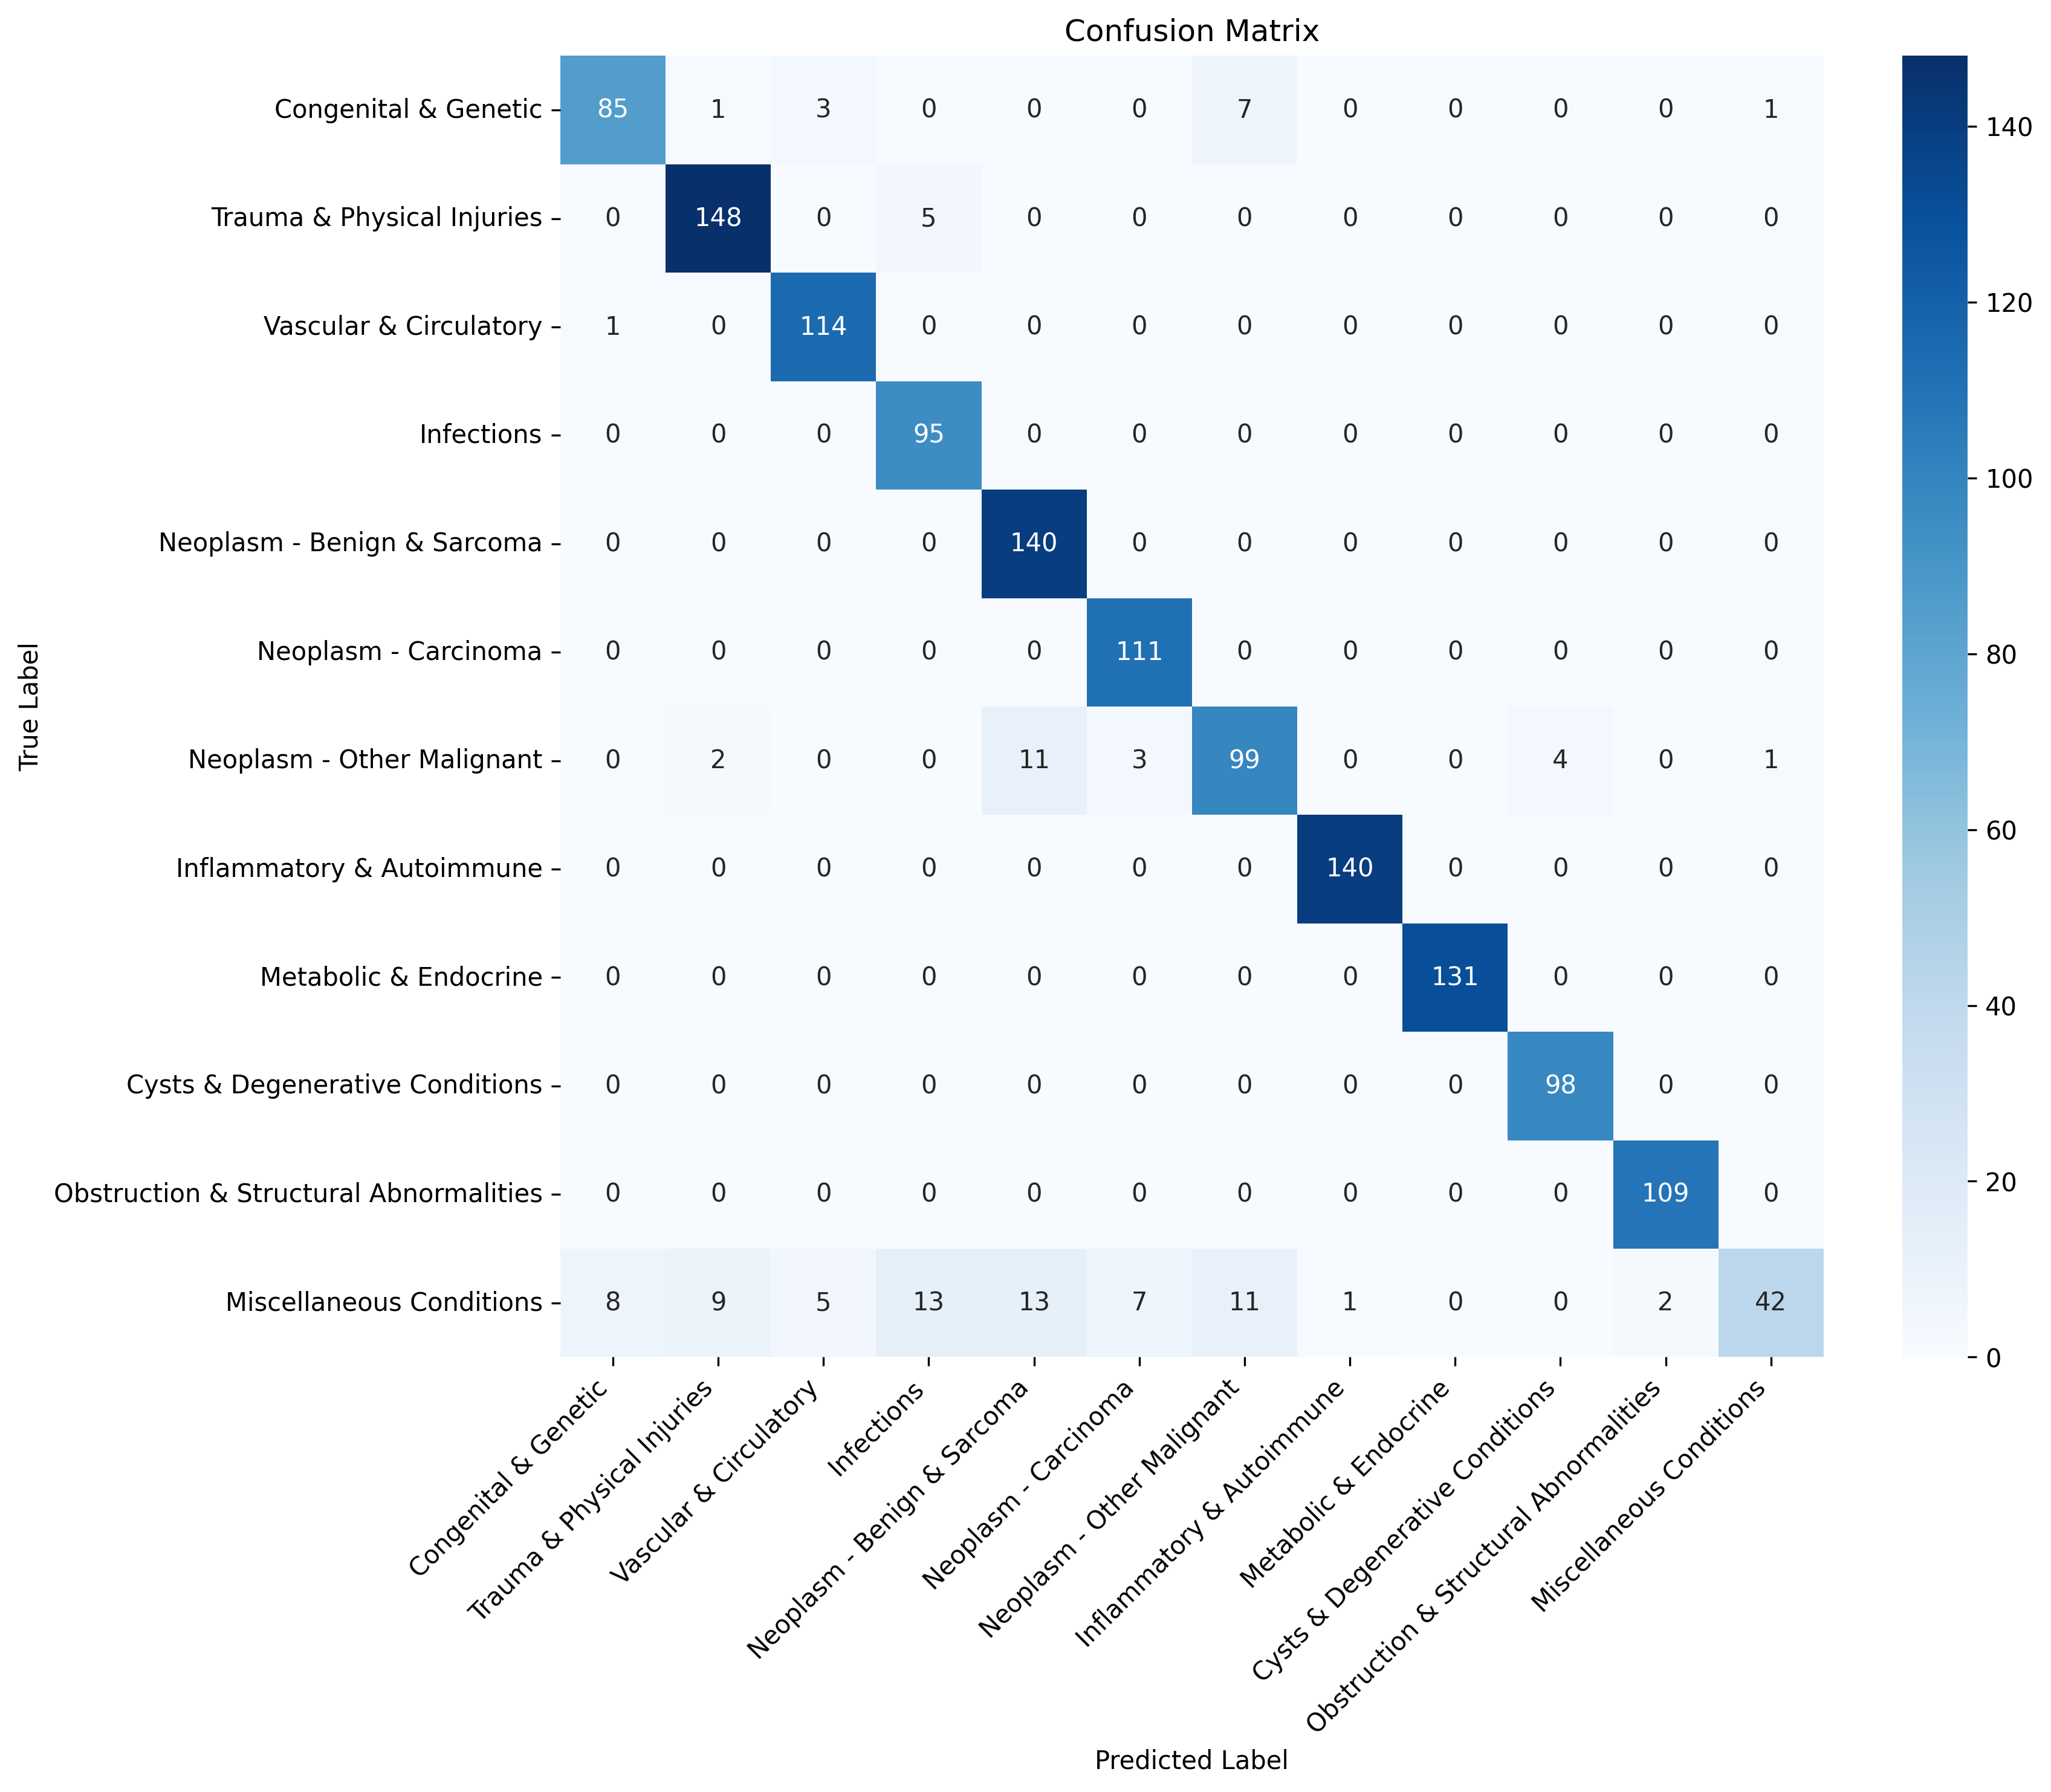
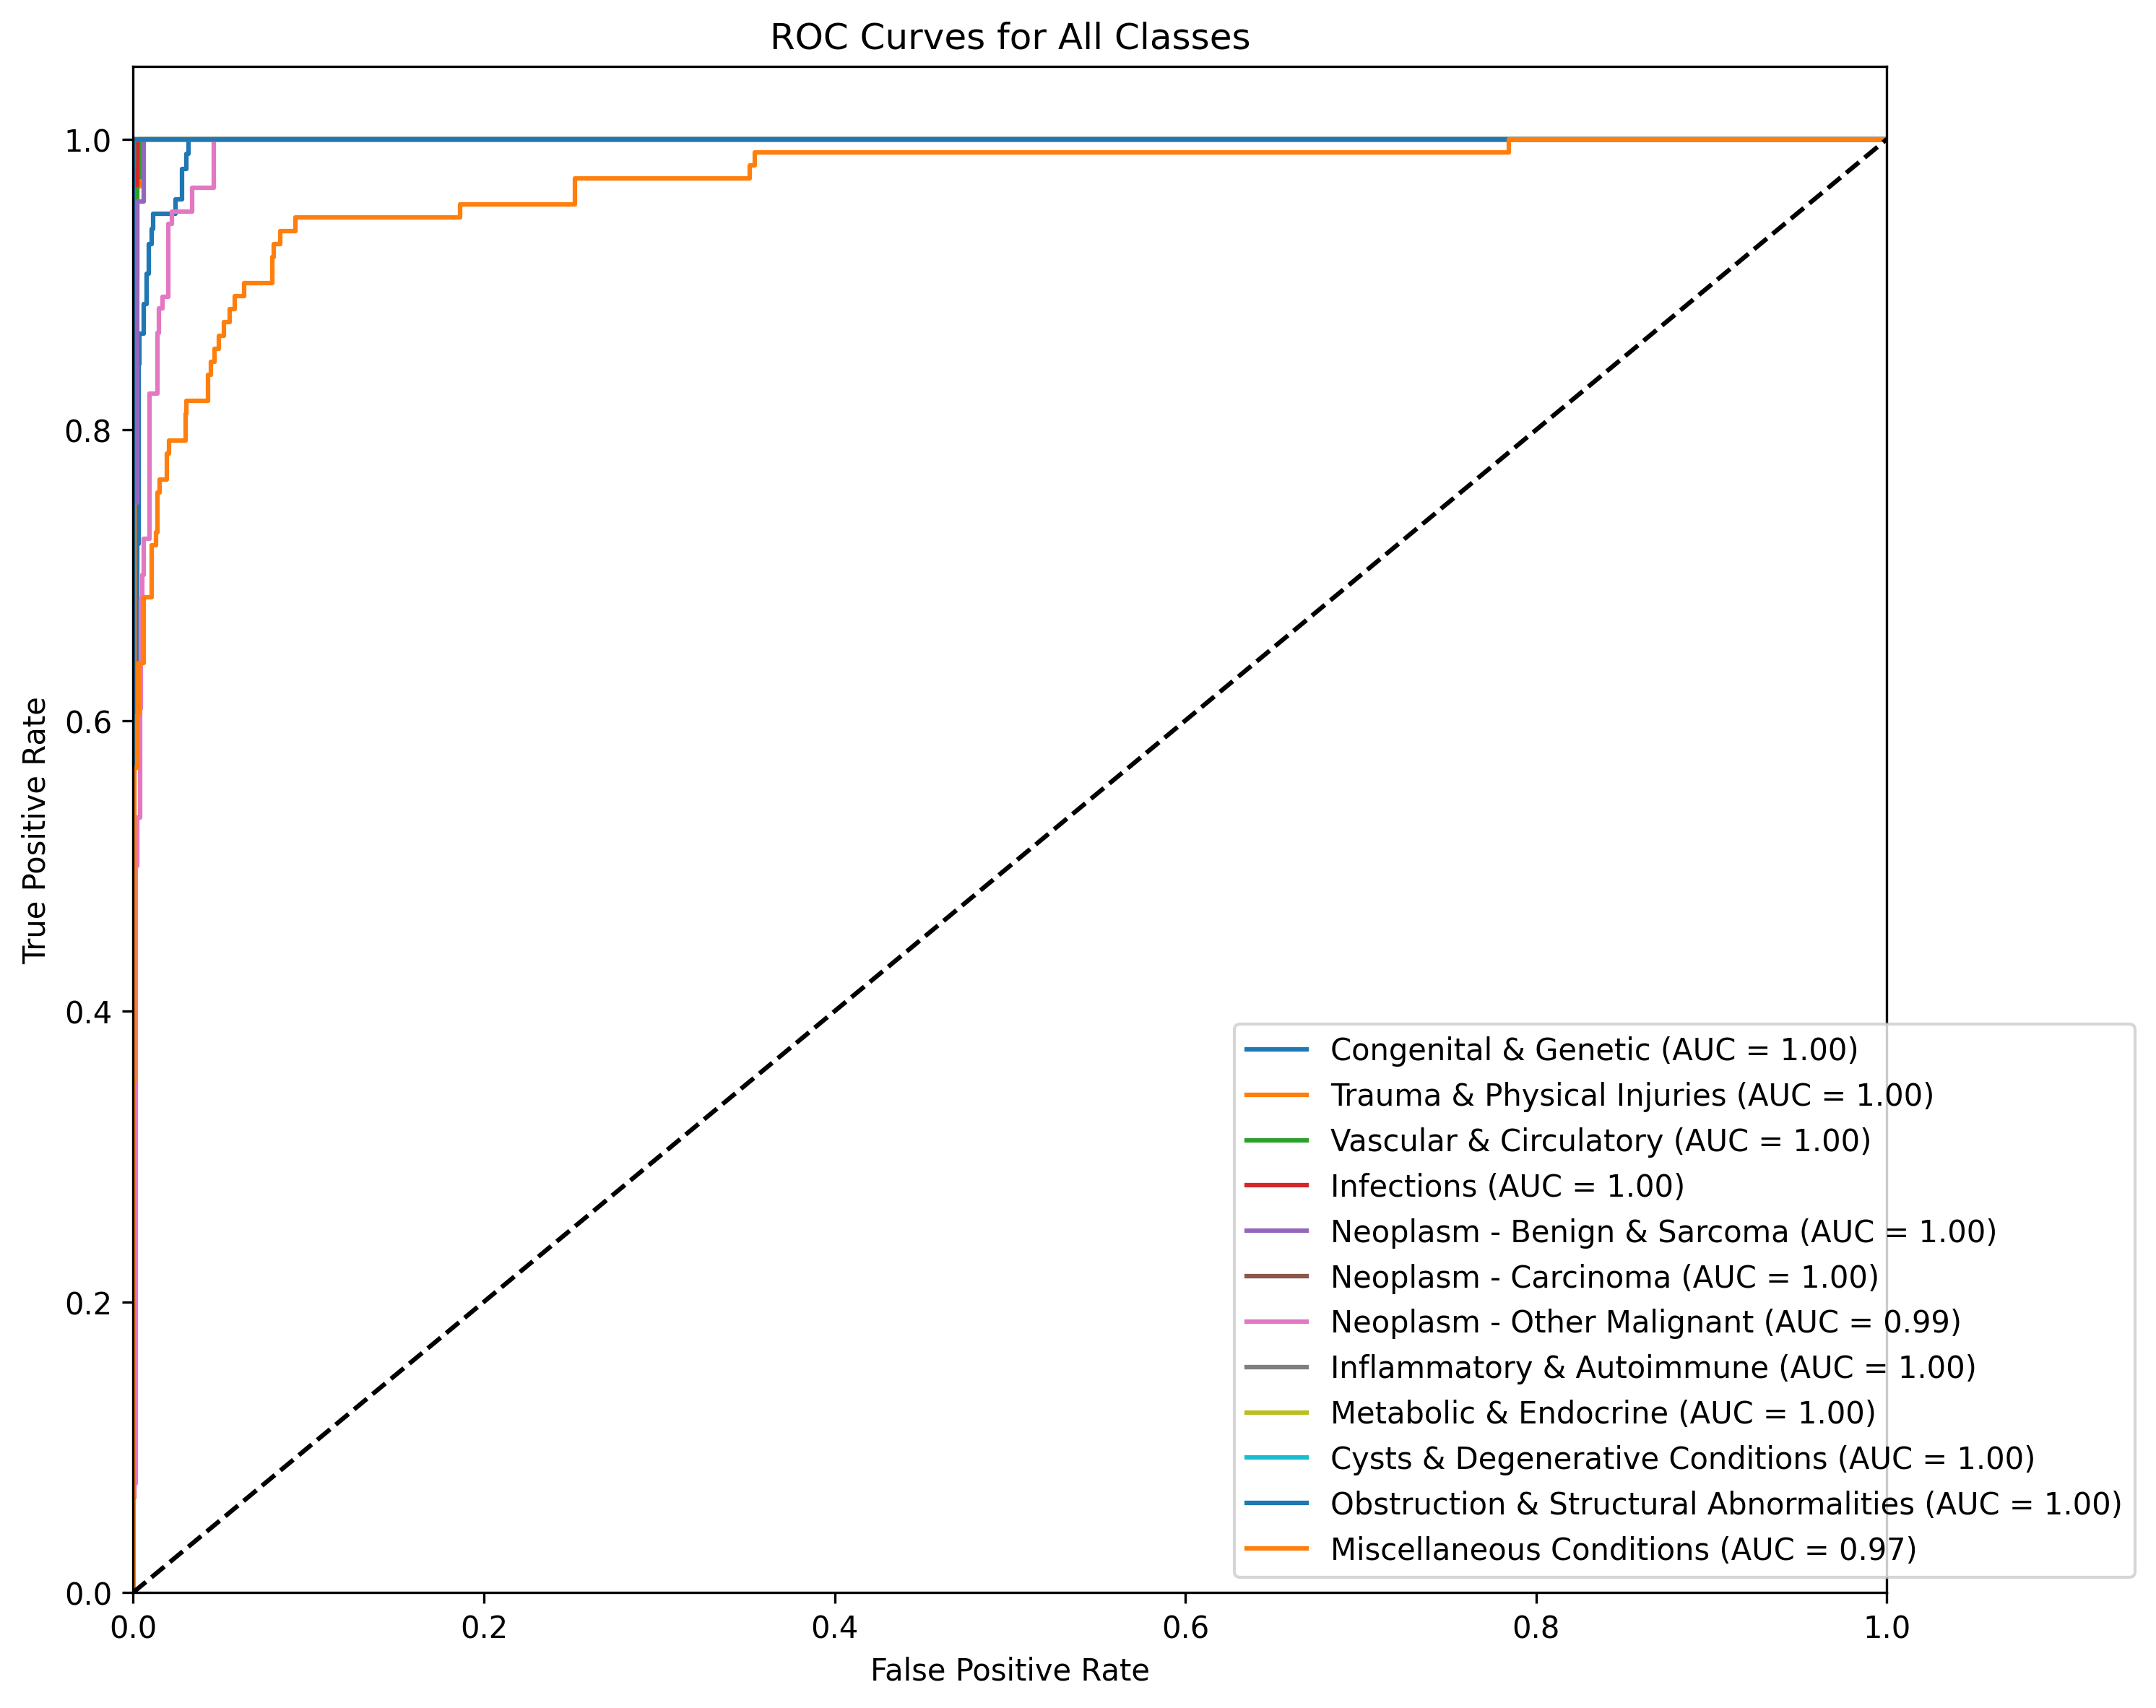

In [ ]:
json_file = "/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Image_2_Augmented.json"

def main():
    classifier = MedicalTextClassifier(json_file)
    X_train_tfidf, X_test_tfidf, y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba = classifier.train()
    classifier.evaluate(y_train, y_test, y_train_pred, y_test_pred, y_test_pred_proba)

if __name__ == "__main__":
    main()

#=====================================================================================================